# 02. Extraindo CSI dos PCAPs

O primeiro passo do pré-processamento é extrair a informação CSI do PCAPs.

O README.md informa o seguinte:
> ### CSI extraction with Matlab and generation of CSI samples 
>
>To extract the CSI data from the captured Pcap files, we leverage Matlab. However, you can also use Python parsing(I have started using Python, it's faster). The Matlab scripts are in the ```SiMWiSense/Matlab_code/``` directory. <br/>
>
>**(I)** At first extract the CSI from the pcap files by executing the ```CSI_extractor_SimWiSense.m``` script. Please change the ```Test="xxxx"``` field to different Test names. If you want to extract the data for all three above-mentioned tests,  execute the script separately for ```Test="proximity"```, ```Test="coarse"``` and ```Test="fine_grained"``` . 
You can either execute the script from Matlab GUI or from the terminal using: <br/>
>
>```
>matlab -batch "CSI_extractor_SimWiSense.m; exit;"
>```
><br/>


**Alguns pontos:**

- CSI significa Channel State Information.
- Cada amostra CSI é composta por dois valores (amplitude e fase) para cada subportadora. No código é utilizado o CSI é tratado como um número complexo.
- A modulação do Wifi divide o sinal em subportadores ortogonais, que no canal utilizado com largura de banda 80MHz, possui 256 subportadoras. O artigo menciona que foram consideradas apenas subportadoras utilizadas na transmissão de dados, descartando as dos tipos null e guard. No código são selecionadas 242 suportadoras (7 a 128 e 132 a 251).
- Isso quer dizer que para cada amostra em um instante t, são capturados 242 complexos.
- A quantidade de amostras está relacionada ao número de pacotes (duração) do PCAP.
- Como já vimos, possuimos 264 PCAPs e esse passo vai gerar exatamente 264 extrações de CSI. Essas extrações são salvas em arquivos de .mat, matrizes de matlab.


In [ ]:
!find ../Data -type d -name CSI_pcap | while read dir; do     parent_dir=$(dirname "$dir");     count=$(find "$parent_dir" -type f -name '*.mat' | wc -l);     total_bytes=$(find "$parent_dir" -type f -name '*.mat' -exec du -bc {} + | grep total$ | awk '{print $1}');     if [ "$count" -gt 0 ]; then         avg_bytes=$((total_bytes / count));         avg_human=$(numfmt --to=iec --suffix=B "$avg_bytes");         total_human=$(numfmt --to=iec --suffix=B "$total_bytes");     else         avg_human="N/A";         total_human="0B";     fi;     BLUE='\033[1;34m';     GREEN='\033[1;32m';     YELLOW='\033[1;33m';     MAGENTA='\033[1;35m';     NC='\033[0m';     echo -e "${BLUE}$parent_dir${NC} -> ${GREEN}$count arquivos${NC}, ${YELLOW}Total: $total_human${NC}, ${MAGENTA}Média: $avg_human${NC}"; done

../Data/coarse/Classroom/80MHz/3mo/m2 -> 5 arquivos, Total: 1,8GB, Média: 350MB
../Data/coarse/Classroom/80MHz/3mo/m3 -> 4 arquivos, Total: 1,8GB, Média: 439MB
../Data/coarse/Classroom/80MHz/3mo/m1 -> 4 arquivos, Total: 1,7GB, Média: 427MB
../Data/coarse/Office/80MHz/3mo/m2 -> 4 arquivos, Total: 1,9GB, Média: 467MB
../Data/coarse/Office/80MHz/3mo/m3 -> 4 arquivos, Total: 1,8GB, Média: 443MB
../Data/coarse/Office/80MHz/3mo/m1 -> 4 arquivos, Total: 1,8GB, Média: 448MB
../Data/proximity/Classroom/80MHz/3mo/m2 -> 20 arquivos, Total: 14GB, Média: 683MB
../Data/proximity/Classroom/80MHz/3mo/m3 -> 20 arquivos, Total: 14GB, Média: 705MB
../Data/proximity/Classroom/80MHz/3mo/m1 -> 20 arquivos, Total: 14GB, Média: 681MB
../Data/proximity/Office/80MHz/3mo/m2 -> 20 arquivos, Total: 23GB, Média: 1,2GB
../Data/proximity/Office/80MHz/3mo/m3 -> 20 arquivos, Total: 22GB, Média: 1,1GB
../Data/proximity/Office/80MHz/3mo/m1 -> 20 arquivos, Total: 22GB, Média: 1,1GB
../Data/fine_grained/Classroom/80MHz/3mo

In [15]:
!ls -lah ../Data/fine_grained/Classroom/80MHz/3mo/m2/A/A.mat

!ls -lah ../Data/fine_grained/Classroom/80MHz/3mo/m2/CSI_pcap/A.pcap

-rw-rw-r-- 1 diogo diogo 1,2G abr 17 16:28 ../Data/fine_grained/Classroom/80MHz/3mo/m2/A/A.mat
-rwxrwxrwx 1 diogo diogo 1,1G ago 10  2023 ../Data/fine_grained/Classroom/80MHz/3mo/m2/CSI_pcap/A.pcap


- Os arquivos .mat são ainda maiores do que os PCAPs.


**Alguns pontos sobre o código**
- O código de extração filtra pacotes com base no chip do wifi
- Ele pula uma parte do pcap que diz ser do cabeçalho
- Utiliza o uma função em C chamada unpack_float_acphy para pegar o CSI dentro do pacote. Parece que é um código do NexMon.

In [ ]:
# Read a matlab .mat file
# Please use HDF reader for matlab v7.3 files, e.g. h5py
import h5py
import numpy as np

file_name = '../Data/fine_grained/Classroom/80MHz/3mo/m2/A/A.mat'

with h5py.File(file_name, 'r') as f:
    print("Keys in the .mat file:")
    for key in f.keys():
      print(key)

    # Access a dataset
    data = f['csi'][:]  # Replace 'A' with the actual key you want to access
    print("\nData shape:", data.shape)
    print("Data type:", data.dtype)


Keys in the .mat file:
csi

Data shape: (242, 1071731)
Data type: [('real', '<f8'), ('imag', '<f8')]


**<f7** significa

- **f** significa Float
- **8** significa 8 bytes, ou seja, tipo float64
- **<** significa little-endian, o endereço menos significativo vem primeiro.


In [71]:
# Examplo das CSI, 242 subportadoras no instante 0
data.T[0]['imag'].min()

np.float64(-1263.0)

In [88]:
def getMinMax(mat_file_path):
  with h5py.File(mat_file_path, 'r') as f:
    csi_data = f['csi'][:]
    real = csi_data['real']
    imag = csi_data['imag']

    min_real = np.min(real)
    max_real = np.max(real)
    min_imag = np.min(imag)
    max_imag = np.max(imag)

    return min_real, max_real, min_imag, max_imag, csi_data.shape[0], csi_data.shape[1]
  
# Example usage
mat_file_path = '../Data/fine_grained/Classroom/80MHz/3mo/m2/A/A.mat'
min_real, max_real, min_imag, max_imag, shape0, shape1 = getMinMax(mat_file_path)

In [87]:
shape[0]

242

In [94]:
from pathlib import Path
from tqdm import tqdm

df_proto = {
    'test': [],
    'environment': [],
    'monitor': [],
    'activity': [],
    'min_real': [],
    'max_real': [],
    'min_imag': [],
    'max_imag': [],
    'shape0': [],
    'shape1': [],
    'file_path': []

}

file_paths = Path('../Data').rglob('*.mat')

for file_path in tqdm(sorted(file_paths)):
  file_path = str(file_path)
  file_path_splited = file_path.split('/')
  test = file_path_splited[2]
  environment = file_path_splited[3]
  monitor = file_path_splited[6]
  activity = file_path_splited[8].split('.')[0]
  min_real, max_real, min_imag, max_imag, shape0, shape1 = getMinMax(file_path)  
  df_proto['test'].append(test)
  df_proto['environment'].append(environment)
  df_proto['monitor'].append(monitor)
  df_proto['activity'].append(activity)
  df_proto['min_real'].append(min_real)
  df_proto['max_real'].append(max_real)
  df_proto['min_imag'].append(min_imag)
  df_proto['max_imag'].append(max_imag)
  df_proto['shape0'].append(shape0)
  df_proto['shape1'].append(shape1)
  df_proto['file_path'].append(file_path)




100%|██████████| 264/264 [34:16<00:00,  7.79s/it]


In [96]:
import pandas as pd
df = pd.DataFrame(df_proto)
df.to_csv('SAIDAS/02-mat_summary.csv', index=False)

In [97]:
df = pd.read_csv('SAIDAS/02-mat_summary.csv')
df.describe()

,min_real,max_real,min_imag,max_imag,shape0,shape1
count,264.000000,264.000000,264.000000,264.000000,264.0,2.640000e+02
mean,-2045.621212,2045.973485,-2045.117424,2046.098485,242.0,8.292726e+05
std,6.201349,4.529084,10.343044,4.088117,0.0,2.987440e+05
min,-2047.000000,2002.000000,-2047.000000,2008.000000,242.0,3.217780e+05
25%,-2047.000000,2047.000000,-2047.000000,2047.000000,242.0,4.623090e+05
50%,-2047.000000,2047.000000,-2047.000000,2047.000000,242.0,1.004204e+06
75%,-2047.000000,2047.000000,-2047.000000,2047.000000,242.0,1.076332e+06
max,-1984.000000,2047.000000,-1937.000000,2047.000000,242.0,1.212282e+06


**Alguns pontos:**
- O intervalo dos dois campos é [-2047, 2047], real e imaginário

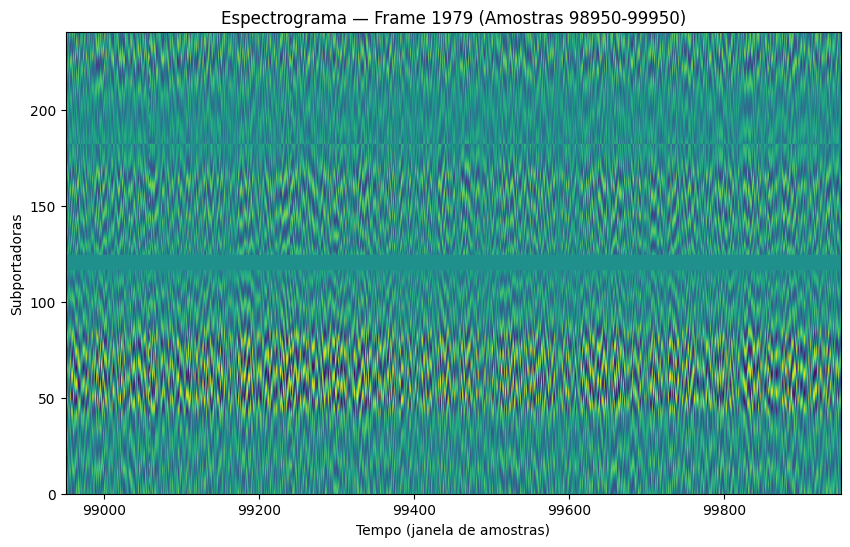

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl

mpl.rcParams['animation.embed_limit'] = 30 * 1024 * 1024  # 30 MB


matrix = data.T[:100000,:]
amplitude = matrix['real']
phase = matrix['imag']

# Parâmetros da janela
window_size = 1000  # Número de amostras por janela
step = 50         # Passo da janela
frames = (len(amplitude) - window_size) // step

# Configurando a figura
fig, ax = plt.subplots(figsize=(10, 6))
heatmap = ax.imshow(amplitude[0:window_size].T,
                    aspect='auto', cmap='viridis',
                    origin='lower',
                    extent=[0, window_size, 0, 241])

ax.set_xlabel('Tempo (janela de amostras)')
ax.set_ylabel('Subportadoras')
title = ax.set_title('Espectrograma — Frame 0')

# Função de atualização
def update(frame):
    start = frame * step
    end = start + window_size
    data = amplitude[start:end].T
    heatmap.set_data(data)
    heatmap.set_extent([start, end, 0, 241])
    title.set_text(f'Espectrograma — Frame {frame} (Amostras {start}-{end})')
    return heatmap, title

# Criando a animação
ani = animation.FuncAnimation(fig, update, frames=frames, interval=100, blit=True)

# Para Jupyter: mostrar como HTML5 video
# from IPython.display import HTML
# HTML(ani.to_jshtml())
ani.save('espectrograma.mp4', writer='ffmpeg', fps=30)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl

mpl.rcParams['animation.embed_limit'] = 30 * 1024 * 1024  # 30 MB

def plot_mat(mat_file_name, window_size=1000, step=100, output_dir='./SAIDAS', n_samples=100000):
  with h5py.File(mat_file_name, 'r') as f:
    data = f['csi'][:] 

  file_path_splited = mat_file_name.split('/')
  test = file_path_splited[2]
  environment = file_path_splited[3]
  monitor = file_path_splited[6]
  activity = file_path_splited[8].split('.')[0]
  output_file = f'{output_dir}/02-espectograma_{test}_{environment}_{monitor}_{activity}.mp4'

  matrix = data.T[:n_samples,:]
  amplitude = matrix['real']
  phase = matrix['imag']
  combined = np.sqrt(amplitude**2 + phase**2)

  # Parâmetros da janela
  # window_size = 3000  # Número de amostras por janela
  # step = 100         # Passo da janela
  frames = (len(amplitude) - window_size) // step

  # Configurando a figura
  fig, ax = plt.subplots(figsize=(10, 6))
  heatmap = ax.imshow(combined[0:window_size].T,
                      aspect='auto', cmap='viridis',
                      origin='lower',
                      extent=[0, window_size, 0, 241])

  ax.set_xlabel('Tempo (janela de amostras)')
  ax.set_ylabel('Subportadoras')
  titulo = f'{test} {environment} {monitor} {activity}'
  title = ax.set_title(titulo)

  # Função de atualização
  def update(frame):
      start = frame * step
      end = start + window_size
      data = combined[start:end].T
      heatmap.set_data(data)
      heatmap.set_extent([start, end, 0, 241])
      # title.set_text(f'Espectrograma — Frame {frame} (Amostras {start}-{end})')
      return heatmap, title

  # Criando a animação
  ani = animation.FuncAnimation(fig, update, frames=frames, interval=100, blit=True)

  ani.save(output_file, writer='ffmpeg', fps=30)

In [1]:
mat_file_name = '../Data/fine_grained/Classroom/80MHz/3mo/m2/A/A.mat'
# mat_file_name = '../Data/fine_grained/Classroom/80MHz/3mo/m2/B/B.mat'
# mat_file_name = '../Data/fine_grained/Classroom/80MHz/3mo/m2/C/C.mat'
plot_mat(mat_file_name, n_samples=40000, window_size=250, step=50, output_dir='./SAIDAS')


NameError: name 'plot_mat' is not defined

In [ ]:
!ffmpeg -i SAIDAS/02-espectograma_fine_grained_Classroom_m2_A.mp4 -i SAIDAS/02-espectograma_fine_grained_Classroom_m2_B.mp4 -i SAIDAS/02-espectograma_fine_grained_Classroom_m2_C.mp4 -filter_complex "vstack=inputs=3" SAIDAS/02-espectograma_fine_grained_Classroom_m2_ABC.mp4

ffmpeg version 6.1.1-3ubuntu5+esm2 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13 (Ubuntu 13.2.0-23ubuntu4)
  configuration: --prefix=/usr --extra-version=3ubuntu5+esm2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --disable-omx --enable-gnutls --enable-libaom --enable-libass --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libharfbuzz --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib